# Plan projektu:

- wizualizacja danych
- czy grayscaling pomaga i wniosek że w sumie nie psuje
- KNN
- PCA/KPCA a następnie KNN
- Gradient boosting
- SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy.stats as sstats
from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import (datasets, decomposition, ensemble, manifold, random_projection)
from sklearn.ensemble import GradientBoostingClassifier

from tqdm import tqdm

from KNN import KNN

## Data visualization
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_batch_1 = unpickle('cifar10/data_batch_1')
db1_labels = np.array(data_batch_1[b'labels'])
db1_data = np.array(data_batch_1[b'data'])

In [3]:
def make_viewables(db_data_photos):
    res = []
    for i in range(db_data_photos.shape[0]):
        res.append(db_data_photos[i].reshape(3,1024).T.reshape(32,32,3))
    return np.array(res)

db1_df = make_viewables(db1_data)

In [4]:
photo_indexes_to_show = np.random.randint(0, len(db1_data), size=100)

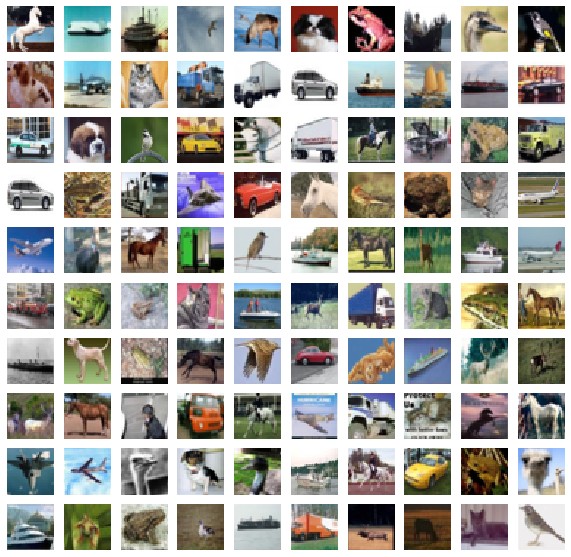

In [5]:
f, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(db1_df[photo_indexes_to_show[10*i+j]])
        axes[i][j].axis('off')
plt.axis('off');

## Does grayscaling affects image classification on this exact dataset?

Since it's speeding up computations.

In [6]:
def to_grayscale(x):
    new_x = x[:,:,0] * 0.3 + x[:, :, 1] * 0.59 + x[:, :, 2] * 0.11
    return new_x.astype(int)

In [7]:
def plot_method_acc(xs, ys, title, xlabel, is_barplot=False):
    plt.figure()
    plt.subplots(figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    if type(xs[0]) is str:
        plt.xticks(np.arange(len(xs)), labels=xs)
    else:
        plt.xticks(xs)
    plt.yticks(np.round(np.linspace(min(ys), max(ys), min(10, len(ys))), 1))
    plt.grid(axis='both', alpha=0.3)
    
    if is_barplot:
        plt.grid(axis='x', alpha=0)
        plt.bar(xs, height=ys)
    else:
        plt.plot(xs, ys)

In [8]:
train_x, test_x, train_y, test_y = train_test_split(db1_data, db1_labels, test_size=0.33)
train_x = train_x.reshape(-1, 32*32, 3)
test_x = test_x.reshape(-1, 32*32, 3)
gray_train_x = to_grayscale(train_x)
gray_test_x = to_grayscale(test_x)

In [9]:
ks = np.arange(1, 30, 2)
knn = KNN(train_x.reshape(-1, db1_data.shape[1]), train_y, test_x.reshape(-1, db1_data.shape[1]), ks)

original = []
grayscaled = []

for k in ks:
    original.append(np.count_nonzero(knn[k] == test_y) / len(test_y) * 100)

knn = KNN(gray_train_x, train_y, gray_test_x, ks)
for k in ks:
    grayscaled.append(np.count_nonzero(knn[k] == test_y) / len(test_y) * 100)

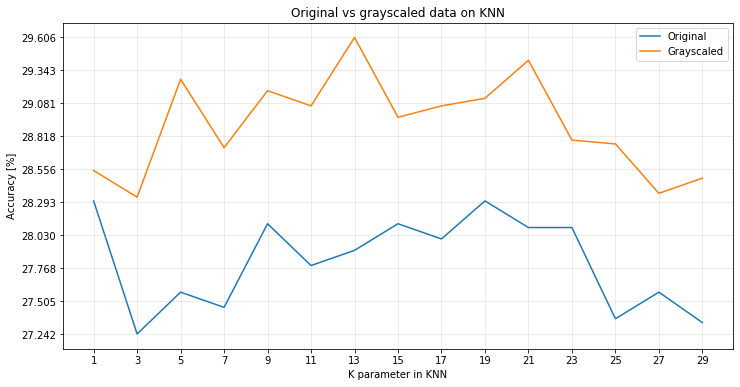

In [10]:
plt.subplots(figsize=(12,6))
plt.plot(ks, np.array(original), label='Original')
plt.plot(ks, np.array(grayscaled), label='Grayscaled')
plt.title('Original vs grayscaled data on KNN')
plt.xlabel('K parameter in KNN')
plt.ylabel('Accuracy [%]')
plt.xticks(ks)
plt.yticks(np.linspace(min(np.min(original), np.min(grayscaled)), max(np.max(original), np.max(grayscaled)), 10))
plt.grid(axis='both', alpha=0.3)
plt.legend();

In [11]:
accuracy_for_method = {}
train_x = gray_train_x
test_x = gray_test_x

## CIFAR-10 classification using k-nearest-neighbours algorithm

#### Comparison of parameters such as:
- number of neighbours to consider

#### Dimension reduction methods:
- sparse random projection
- PCA
- KPCA

<Figure size 432x288 with 0 Axes>

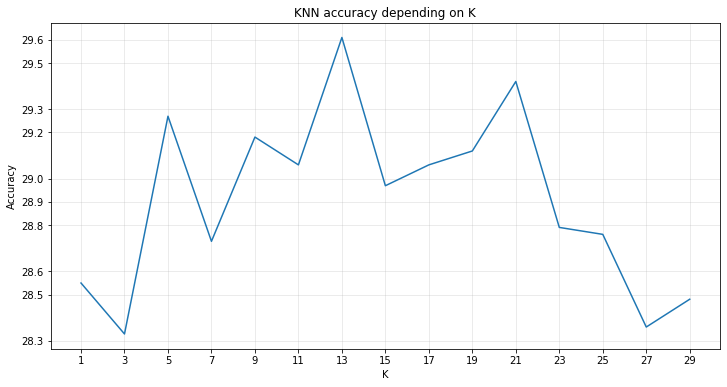

In [12]:
Ks = np.arange(1, 30, 2)
knn = KNN(train_x, train_y, test_x, Ks)
accs = []
for k in Ks:
    accs.append(np.round(np.count_nonzero(knn[k] == test_y) / len(test_y) * 100, 2))

accuracy_for_method['KNN'] = np.max(accs)
plot_method_acc(Ks, accs, 'KNN accuracy depending on K', 'K')

In [13]:
opt_k = Ks[np.argmax(accs)]
print("Best K param: ", opt_k)
print("Accuracy with this k:", np.max(accs))

Best K param:  13
Accuracy with this k: 29.61


### Sparse random projection
opis

In [14]:
def sparseRandomProj(train_x, test_x, train_y, test_y):
    OS = np.arange(10, 150, 5)
    accs = []
    for oss in tqdm(OS, position=0, leave=True):
        srp = random_projection.SparseRandomProjection(n_components=oss)
        x_proj = srp.fit_transform(train_x)
        x_test_proj = srp.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return OS, accs

OS, accs = sparseRandomProj(train_x, test_x, train_y, test_y)
accuracy_for_method['Sparse Random Proj'] = np.max(accs)

100%|██████████| 28/28 [00:59<00:00,  2.13s/it]


<Figure size 432x288 with 0 Axes>

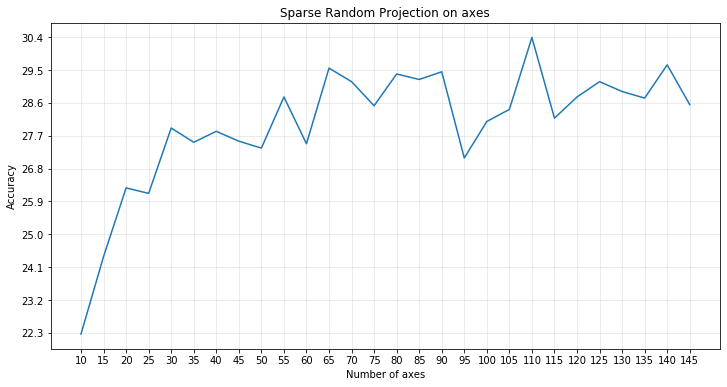

In [15]:
plot_method_acc(OS, accs, 'Sparse Random Projection on axes', 'Number of axes')

### Principial Component Analysis
opis

In [16]:
def pca(train_x, test_x, train_y, test_y):
    OS = np.arange(10, 100, 5)

    accs = []
    for oss in tqdm(OS, position=0, leave=True):
        pca = decomposition.PCA(n_components=oss)
        x_proj = pca.fit_transform(train_x)
        x_test_proj = pca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return OS, accs

OS, accs = pca(gray_train_x, gray_test_x, train_y, test_y)
accuracy_for_method['PCA'] = np.max(accs)

100%|██████████| 18/18 [00:43<00:00,  2.42s/it]


<Figure size 432x288 with 0 Axes>

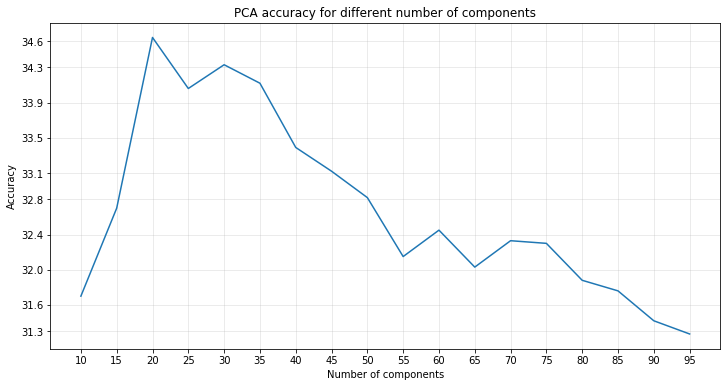

In [17]:
plot_method_acc(OS, accs, 'PCA accuracy for different number of components', 'Number of components')

## Kernelized PCA
Comparison of linear, polynomial, rbf, sigmoid and cosine kernels.

In [18]:
def kpca_kernels_comparison(train_x, test_x, train_y, test_y):
    kers = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

    accs = []
    for ker in tqdm(kers, position=1, leave=True):
        kpca = decomposition.KernelPCA(n_components=None, kernel=ker, gamma=0.01)
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return kers, accs
    
kers, accs = kpca_kernels_comparison(train_x, test_x, train_y, test_y)


100%|██████████| 5/5 [09:42<00:00, 116.49s/it][A


<Figure size 432x288 with 0 Axes>

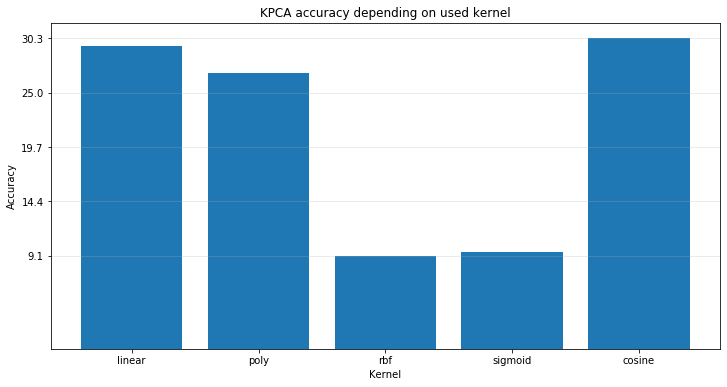

In [19]:
plot_method_acc(kers, accs, 'KPCA accuracy depending on used kernel', 'Kernel', is_barplot=True)

#### KPCA with linear kernel

In [21]:
def KPCA_linear(train_x, test_x, train_y, test_y):
    comps = np.arange(10, 50, 2)
    accs = []
    for i in tqdm(comps, position=0, leave=True):
        kpca = decomposition.KernelPCA(n_components=i, kernel='linear')
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    
    return comps, accs
        
comps, accs = KPCA_linear(train_x, test_x, train_y, test_y)

100%|██████████| 20/20 [09:20<00:00, 28.03s/it]


KeyError: 'KPCA'

In [22]:
accuracy_for_method['KPCA_lin'] = np.max(accs)

<Figure size 432x288 with 0 Axes>

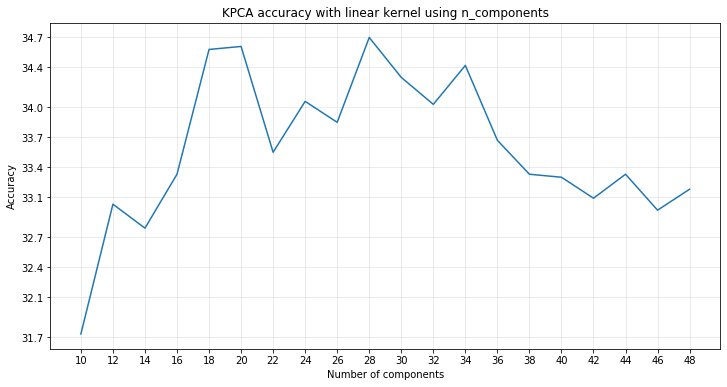

In [23]:
plot_method_acc(comps, accs, 'KPCA accuracy with linear kernel using n_components', 'Number of components')

#### KPCA with polynomial kernel

In [24]:
def KPCA_poly_deg(train_x, test_x, train_y, test_y):
    degrees = np.arange(1, 8, 1)
    accs = []
    for g in tqdm(degrees, position=0, leave=True):
        kpca = decomposition.KernelPCA(n_components=12, kernel='poly', degree=g)
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return degrees, accs

degrees, accs = KPCA_poly_deg(train_x, test_x, train_y, test_y)

100%|██████████| 7/7 [03:20<00:00, 28.64s/it]


NameError: name 'accuracy_for_methos' is not defined

In [26]:
accuracy_for_method['KPCA_poly'] = np.max(accs)

<Figure size 432x288 with 0 Axes>

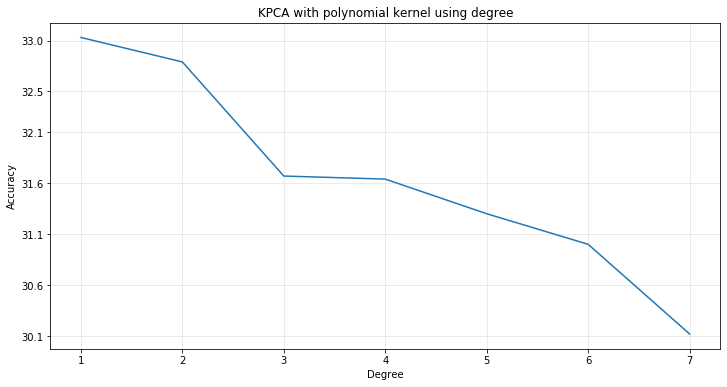

In [27]:
plot_method_acc(degrees, accs, 'KPCA with polynomial kernel using degree', 'Degree')

#### KPCA with cosine kernel

In [34]:
def KPCA_cos_comps(train_x, test_x, train_y, test_y):
    comps = np.append(np.arange(10,30,2), [40,50,60,90,150,300])
    accs = []
    for i in tqdm(comps, position=0, leave=True):
        kpca = decomposition.KernelPCA(n_components=i, kernel='cosine')
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [opt_k])

        acc = np.round(np.count_nonzero(knn[opt_k] == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return comps, accs

comps, accs = KPCA_cos_comps(train_x, test_x, train_y, test_y)
accuracy_for_method['KPCA_cos'] = np.max(accs)

100%|██████████| 16/16 [07:29<00:00, 28.07s/it]


<Figure size 432x288 with 0 Axes>

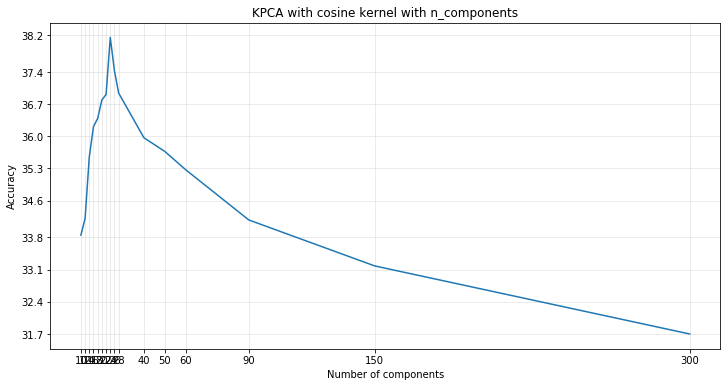

In [35]:
plot_method_acc(comps, accs, 'KPCA with cosine kernel with n_components', 'Number of components')

#### Gradient Boosting Classifier

In [57]:
def gradient_boost(train_x, test_x, train_y, test_y):
    max_depths = np.arange(1, 6)
    accs = []
    
    for md in tqdm(max_depths, position=1, leave=True):
        clf = GradientBoostingClassifier(max_depth=md)    
        clf.fit(train_x, train_y)
        preds = clf.predict(test_x)
        acc = np.round(np.count_nonzero(preds == test_y) / len(test_y) * 100, 2)
        accs.append(acc)
    return max_depths, accs        

In [58]:
max_depths, accs = gradient_boost(train_x, test_x, train_y, test_y)
accuracy_for_method['Gradient Boosting'] = np.max(accs)


100%|██████████| 5/5 [33:41<00:00, 404.40s/it]


<Figure size 432x288 with 0 Axes>

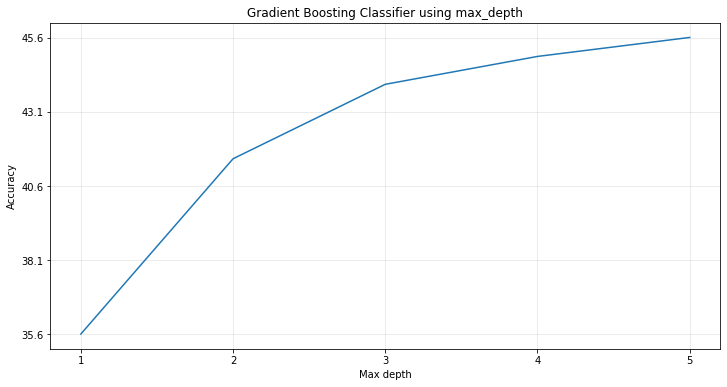

In [59]:
plot_method_acc(max_depths, accs, 'Gradient Boosting Classifier using max_depth', 'Max depth')

#### Support Vector Classifier

In [60]:
def svm(train_x, test_x, train_y, test_y):
    k = 'poly'
    degrees = np.arange(1, 6)
    accs = []

    for d in tqdm(degrees, position=0, leave=True):
        svc = SVC(kernel=k, gamma='scale', degree=d)
        svc.fit(train_x, train_y)
        preds = svc.predict(test_x)
        acc = np.round(np.count_nonzero(preds == test_y) / len(test_y) * 100, 2)
        accs.append(acc)

    return degrees, accs

In [61]:
degrees, accs = svm(train_x, test_x, train_y, test_y)
accuracy_for_method['Support Vector'] = np.max(accs)

100%|██████████| 5/5 [06:59<00:00, 83.99s/it]


<Figure size 432x288 with 0 Axes>

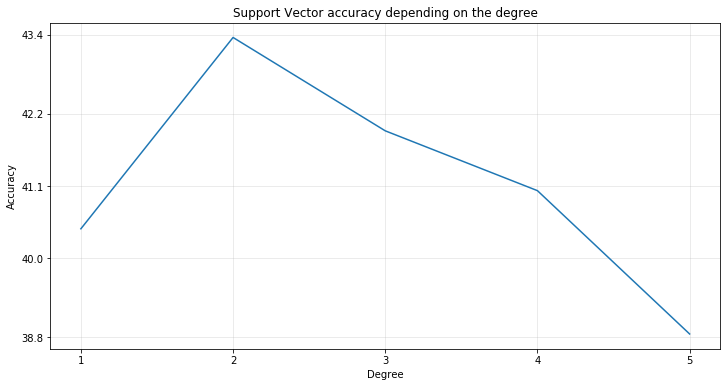

In [62]:
plot_method_acc(degrees, accs, 'Support Vector accuracy depending on the degree', 'Degree')

## Summary

<Figure size 432x288 with 0 Axes>

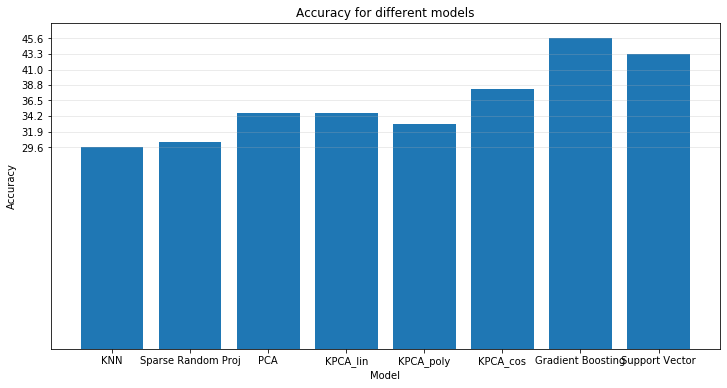

In [63]:
plot_method_acc(list(accuracy_for_method.keys()), list(accuracy_for_method.values()), 
                'Accuracy for different models', 'Model', is_barplot=True)